In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from review_analyzer.plots import show_image

show_image('https://i.imgur.com/XLD0c0o.png')

# 1. Descripción del Problema

El proyecto desarrolla un sistema que analiza emociones y perspectiva (positiva o negativa) en reseñas online sobre productos y servicios, usando NLP y machine learning, para generar insights útiles a marcas y negocios.

Diccionario de datos
| Variable            | Tipo       | Descripción |
|---------------------|------------|-------------|
| `user`              | Object    | Nombre de usuario |
| `user_id`           | int    | ID del usuario |
| `text`              | object | Comentario realizado por el usuario |
| `like`              | int  | Cantidad de likes en un comentario |
| `reply_count`       | int    | Cantidad de respuestas en un comentario |
| `timestamp`         | object  | Codigo de la fecha |
| `fecha_legible`     | object  | fecha del comentario realizado |

# 2. Exploración general

Dataset: Datos obtenidos mediante consulta a las APIs oficiales de plataformas digitales, integrados y preparados para el EDA y limpieza.

In [3]:
from review_analyzer.config import TIKTOK_COMMENTS
import pandas as pd


In [4]:
df = pd.read_csv(TIKTOK_COMMENTS)
df.head()

,user,comment,time,likes,reply_count,origen
0,Joel Equiño Espinoza.,le gana sauvage dior ufff perfumaso .,2025-02-21 10:25:01,296,28,comments-perfume.csv
1,Klaus Heinz,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅,2025-02-21 19:53:11,400,15,comments-perfume.csv
2,jozahel,Me dejan el precio ? No me dejen su Wsp que no...,2025-02-21 08:29:51,337,38,comments-perfume.csv
3,Pilar Acha Mendez,Cuál es su precio?,2025-02-21 20:20:06,4,11,comments-perfume.csv
4,Bas 🫀,"El olor no perdura, pero si huele muy rico, mu...",2025-02-21 10:56:35,15,23,comments-perfume.csv


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user         4650 non-null   object
 1   comment      4651 non-null   object
 2   time         4651 non-null   object
 3   likes        4651 non-null   int64 
 4   reply_count  4651 non-null   int64 
 5   origen       4651 non-null   object
dtypes: int64(2), object(4)
memory usage: 218.1+ KB


In [6]:
df['comment_length'] = df['comment'].astype(str).apply(len)

In [7]:
from review_analyzer.plots import plot_histo

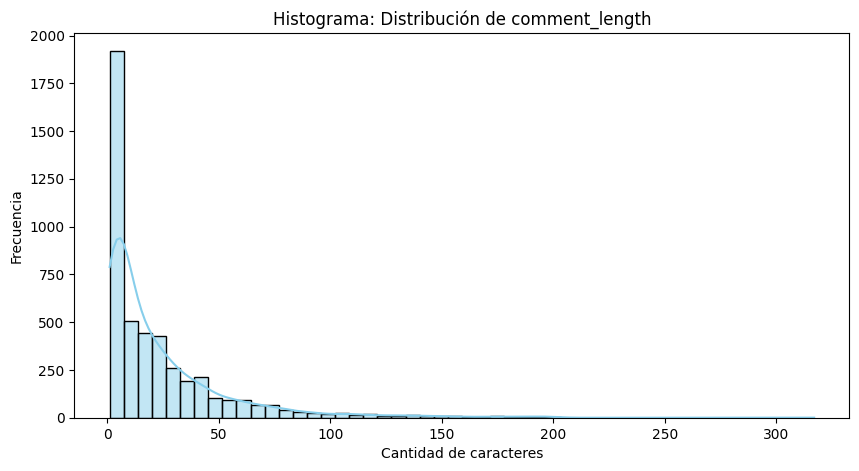

In [8]:
plot_histo(df, 'comment_length')

La gran mayoría de comentarios tienen menos de 20 caracteres.

A partir de los ~100 caracteres, la frecuencia cae casi a cero, y solo aparecen unos pocos comentarios muy largos (outliers).

Tal vez valga la pena establecer un límite superior de longitud para filtrar entradas irrelevantes.

In [9]:
from review_analyzer.plots import plot_comments_by_time

In [10]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')

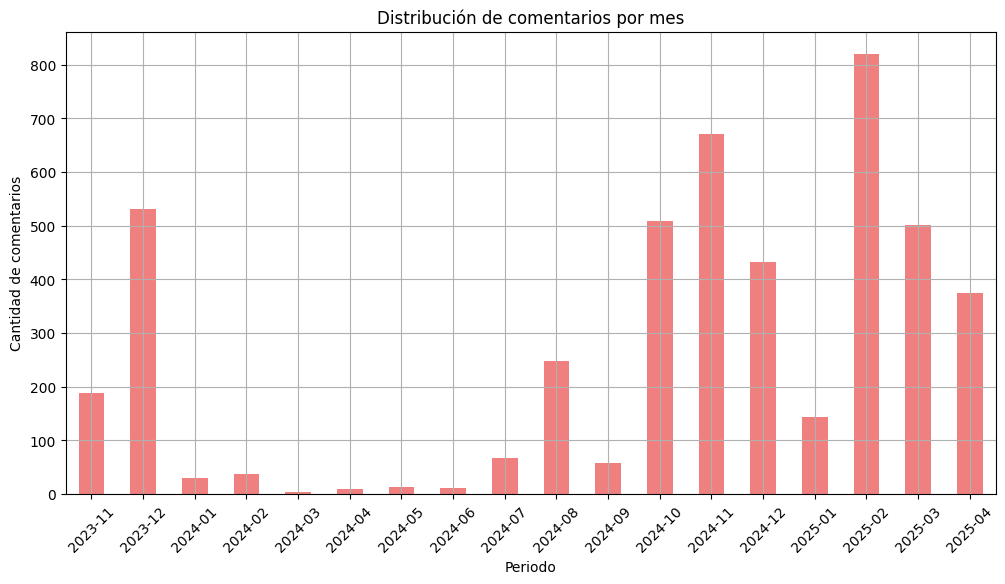

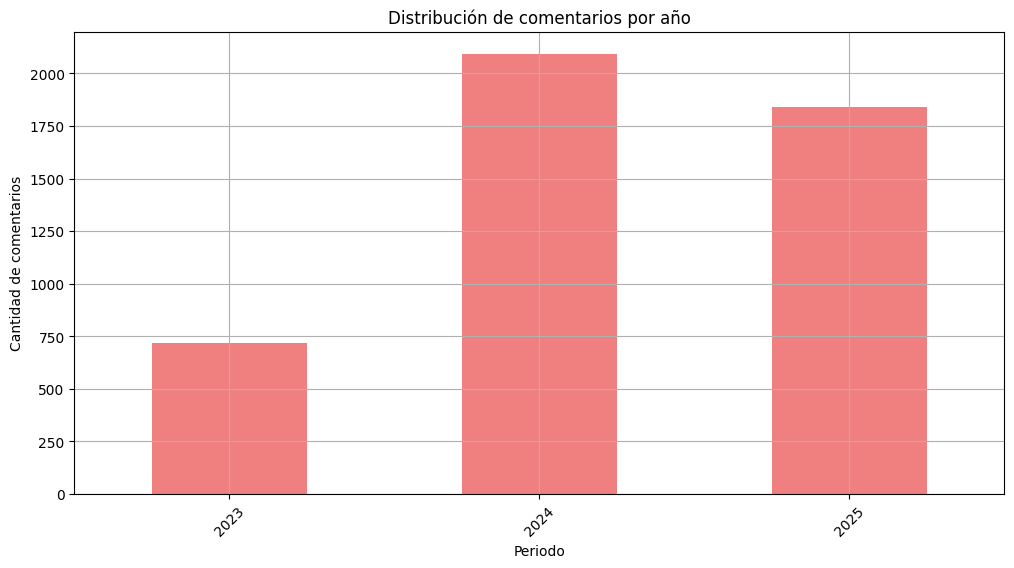

In [11]:
plot_comments_by_time(df, time_column='time', period='M')
plot_comments_by_time(df, time_column='time', period='Y')


Los comentarios no están distribuidos uniformemente en el tiempo: la mayoría de los datos provienen de 2024 y 2025, mientras que 2023 tiene menor representación, por lo que es importante considerar el sesgo temporal al analizar y modelar los datos.

In [12]:
df.describe()

,time,likes,reply_count,comment_length
count,4651,4651.000000,4651.000000,4651.000000
mean,2024-10-24 19:16:20.322081280,3.874006,0.199097,23.452376
min,2023-11-29 19:59:12,0.000000,0.000000,1.000000
25%,2024-09-19 16:26:40.500000,0.000000,0.000000,4.000000
50%,2024-11-27 19:27:25,0.000000,0.000000,12.000000
75%,2025-02-22 09:10:39,0.000000,0.000000,31.000000
max,2025-04-30 22:25:32,3140.000000,38.000000,317.000000
std,NaN,66.311410,1.589186,30.278358


- La mayoría de los comentarios son cortos, sin likes ni respuestas.

- Existen pocos comentarios “virales” con muchos likes o respuestas, que elevan los máximos y promedios.

- El promedio es 23.45 caracteres, con mediana de 12, lo que indica que la distribución está sesgada a la derecha (algunos comentarios son muy largos y elevan el promedio).

- El engagement general (likes y replies) es bajo para la mayoría, pero los outliers dominan las métricas agregadas.

In [13]:
from review_analyzer.plots import plot_correlation_scatter

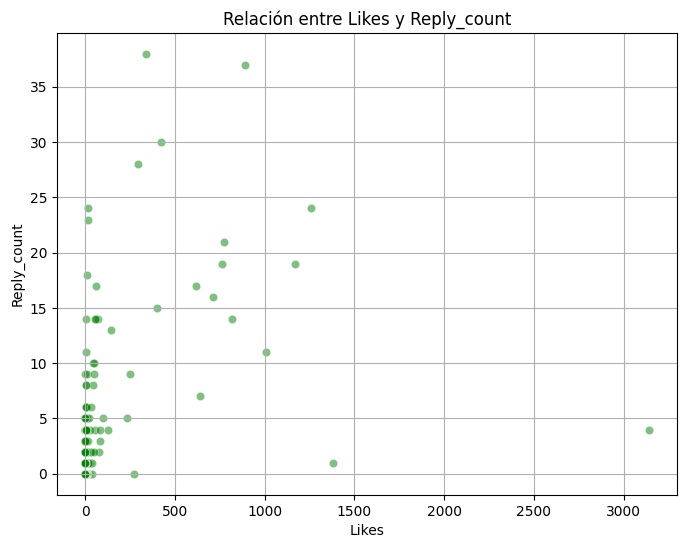

In [14]:
plot_correlation_scatter(df, 'likes', 'reply_count', color='green')

No se observa una correlación clara entre likes y reply_count: la mayoría de los comentarios tiene valores bajos, y los casos con muchos likes no muestran un aumento proporcional en respuestas.

In [20]:
from review_analyzer.plots import plot_language_distribution

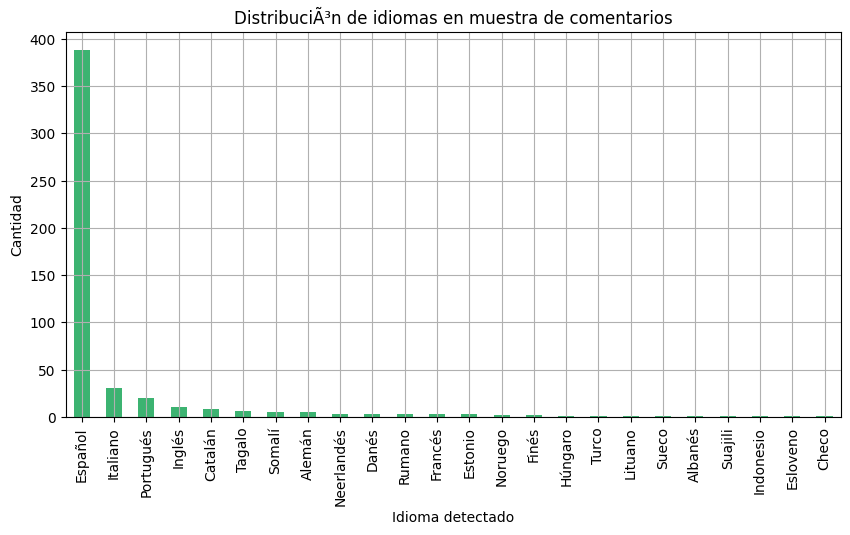

In [21]:
plot_language_distribution(df['comment'], sample_size=500)

La mayoría de los comentarios están en español, con muy poca representación de otros idiomas; se puede trabajar principalmente sobre datos en español sin necesidad de procesamiento multilingüe general.

### Resumen general
- La mayoría de los comentarios son cortos (mediana ≈12 caracteres) y no generan likes ni respuestas; el engagement promedio es bajo, pero existen outliers que distorsionan las métricas (máximos muy altos).

- Los histogramas muestran una distribución sesgada, donde pocos comentarios concentran mucha interacción.
- El scatterplot entre likes y reply_count sugiere una relación débil o ruidosa: la mayoría de los puntos se agrupan en valores bajos, sin una tendencia clara.
- Se recomienda detectar el idioma de los comentarios porque, aunque se asume que la mayoría será en español por contexto temporal y geográfico (2024-2025), es necesario confirmarlo para preparar procesos de limpieza y el análisis de sentimiento.

# 3. Limpieza y Preprocesamiento

text